# Figure 1 - Basic Comparison of Algorithms

May 8, 2022

The following plots outline the basic framework that we have set up.

Three learning rules are compared below: BPTT, RFLO and REINFORCE. 

1. With RFLO and BPTT, we can show how partial alignment of the credit assignment matrix affects the loss over the course of training.

2. With REINFORCE, we can show that different choices of recurrent noise affect the rate of learning

In [1]:
pwd

'/Users/jacobportes/Documents/Code/rnn-learning/experiments/NeurIPS-2022-4-29'

In [30]:
folder = 'figures-2022-5-8/'

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# analysis
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.linear_model import LinearRegression
from scipy import stats, interpolate
from scipy import linalg as LA
from scipy.ndimage.filters import uniform_filter1d

# miscellaneous
from tqdm import tqdm
from itertools import cycle
from copy import deepcopy

import logging
import warnings
import dataclasses
from dataclasses import dataclass
from typing import Optional, List

import sys
sys.path.append("../..")

In [4]:
from rnn import RNNparams, RNN
from task import Task
from simulation import Simulation
from algorithms.bptt import BPTT
from algorithms.rflo import RFLO
from algorithms.reinforce import REINFORCE
from algorithms.track_vars import TrackVars

from utils.plotting import plot_trained_trajectories
from utils.metric import cos_sim, return_norm_and_angle
from utils.functions import choose_aligned_matrix

from utils.metric import cos_sim, flow_field_data, flow_field_predicted, calculate_flow_field_correlation


### Train RNN on four targets

In [5]:
trial_duration = 20
n_in=4
frac_on = 0.2

x_tonic = 0.0*np.ones((trial_duration, n_in)) # shape 20 x 4 i.e. time x channel
x_pulse1 = x_tonic.copy()
x_pulse2 = x_tonic.copy()
x_pulse3 = x_tonic.copy()
x_pulse4 = x_tonic.copy()
x_pulse1[0:int(trial_duration*frac_on),0] = 1
x_pulse2[0:int(trial_duration*frac_on),1] = 1
x_pulse3[0:int(trial_duration*frac_on),2] = 1
x_pulse4[0:int(trial_duration*frac_on),3] = 1

task1 = Task(x_in=x_pulse1,y_target=np.asarray([[1],[1]]))
task2 = Task(x_in=x_pulse2,y_target=np.asarray([[-1],[1]]))
task3 = Task(x_in=x_pulse3,y_target=np.asarray([[1],[-1]]))
task4 = Task(x_in=x_pulse4,y_target=np.asarray([[-1],[-1]]))

### BPTT, RFLO and REINFORCE with the same parameters

23it [00:00, 228.87it/s]

n_in: 4
n_rec: 50
n_out: 2
sig_in: 0.0
sig_rec: 0.25
sig_out: 0.01
tau_rec: 10
dt: 1.0
eta_in: 0.1
eta_rec: 0.25
eta_out: 0.1
g_in: 2.0
g_rec: 1.5
g_out: 2.0
g_fb: 2.0
driving_feedback: False
eta_fb: None
sig_fb: None
feedback_signal: position
velocity_transform: True
tau_vel: 0.8
dt_vel: 0.1
sig_rec_dim: None
eta_m: None
sig_m: None
lam_m: None
rng: <mtrand.RandomState object at 0x7f91b571afc0>
>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


2500it [00:05, 428.98it/s]


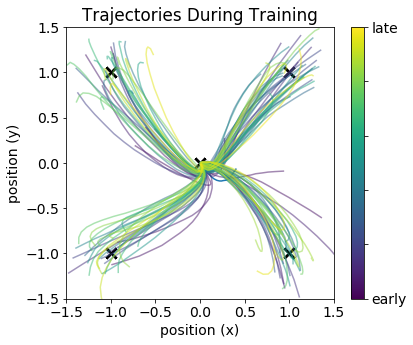

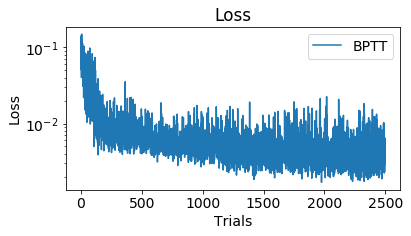

In [6]:
# Set RNN Parameters
params = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,
               sig_in=0.0,sig_rec=0.25,sig_out=0.01,
               velocity_transform=True, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(4))
params.print_params()

# Initialize RNN
net0 = RNN(params)
sim0 = Simulation(net0)
bptt = BPTT(net0,apply_to=['w_rec'],online=False) # something strange happening here
sim0.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[bptt], probe_types=['loss'], plot=True, plot_freq=20)




2500it [00:06, 372.74it/s]


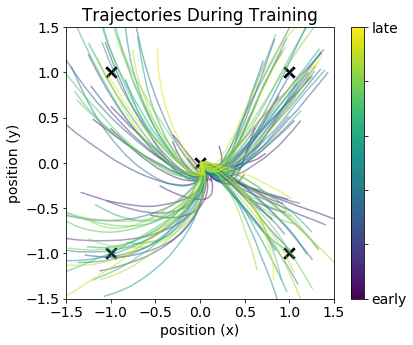

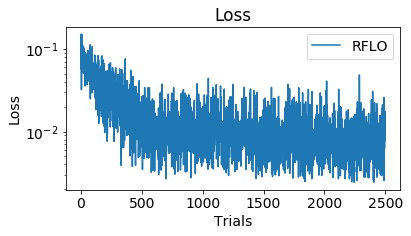

In [7]:
net1 = RNN(params)
sim1 = Simulation(net1)
rflo = RFLO(net1,apply_to=['w_rec'],online=False)
sim1.run_session(n_trials=2500, tasks=[task1,task2,task3,task4], learn_alg=[rflo], probe_types=['loss'], plot=True, plot_freq=20)


50000it [01:34, 528.18it/s]


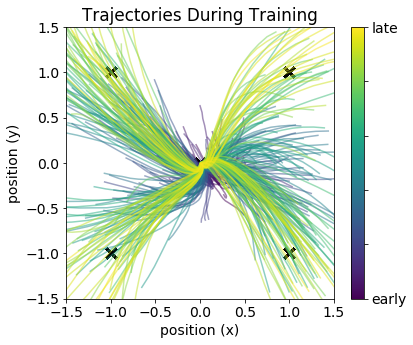

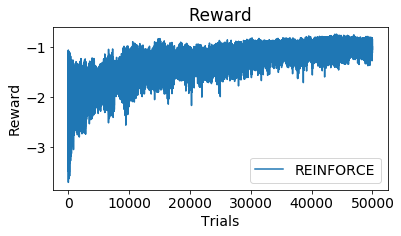

In [80]:
net2 = RNN(params)
sim2 = Simulation(net2)
reinforce = REINFORCE(net2,apply_to=['w_rec'],online=False, tau_reward=5)
sim2.run_session(n_trials=50000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=100)


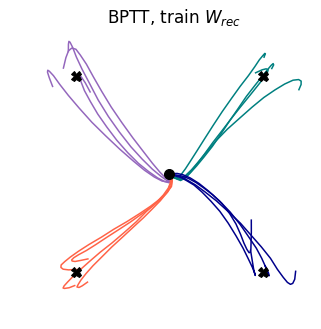

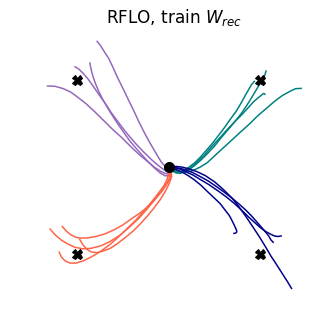

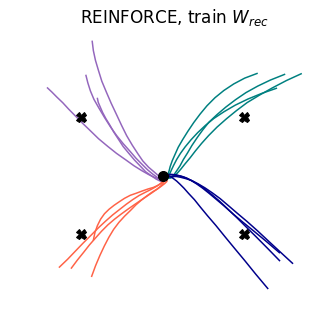

In [87]:
fig0 = plot_trained_trajectories(sim=sim0, tasks=[task1,task2,task3,task4],title='BPTT, train '+r'$W_{rec}$')
fig1 = plot_trained_trajectories(sim=sim1, tasks=[task1,task2,task3,task4],title='RFLO, train '+r'$W_{rec}$')
fig2 = plot_trained_trajectories(sim=sim2, tasks=[task1,task2,task3,task4],title='REINFORCE, train '+r'$W_{rec}$')


save = True
if save:
    fig0.savefig(folder+'fig1-BPTT')
    fig1.savefig(folder+'fig1-RFLO')
    fig2.savefig(folder+'fig1-REINFORCE')

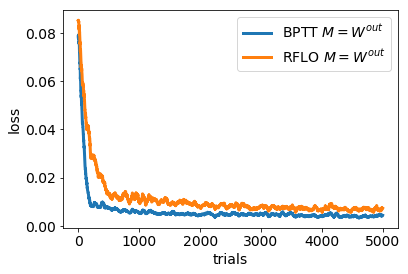

In [88]:
lw=3

fig,ax = plt.subplots(1,1)
av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),50)
ax.plot(av0,linewidth=lw,label='BPTT '+'$M=W^{out}$')

av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),50)
ax.plot(av1,linewidth=lw,label='RFLO '+r'$M = W^{out}$')
ax.legend()
ax.set_xlabel('trials')
ax.set_ylabel('loss')
plt.show()

#ax.fill_between(np.arange(len(av1)),av1-std1,av1+std1,alpha=0.5)
#std1 = uniform_filter1d(np.std(sim1.session_probes['loss'],axis=1),50)


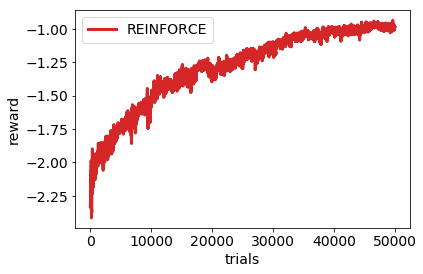

In [90]:
fig,ax = plt.subplots(1,1)
av2 = uniform_filter1d(np.mean(sim2.session_probes['reward'],axis=1),50)
ax.plot(av2,linewidth=lw,label='REINFORCE',color='C3')
ax.legend()
ax.set_xlabel('trials')
ax.set_ylabel('reward')
plt.show()


### Compare alignment of M for RFLO

14it [00:00, 136.63it/s]

M norm: 1.04	 M angle: 0.80, 4 iterations

1500it [00:05, 297.81it/s]
31it [00:00, 301.50it/s]

M norm: 1.38	 M angle: 0.60, 7 iterations

1500it [00:03, 376.21it/s]
27it [00:00, 266.50it/s]

M norm: 1.61	 M angle: 0.39, 40 iterations

1500it [00:03, 376.85it/s]
32it [00:00, 319.94it/s]

M norm: 1.82	 M angle: 0.00, 7 iterations

1500it [00:03, 418.47it/s]


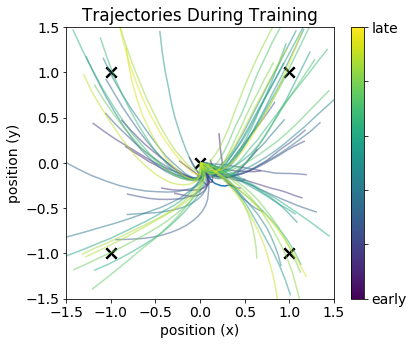

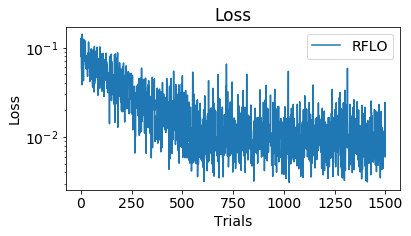

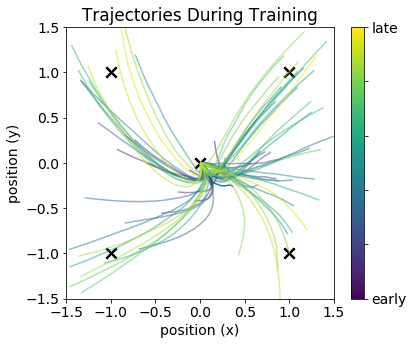

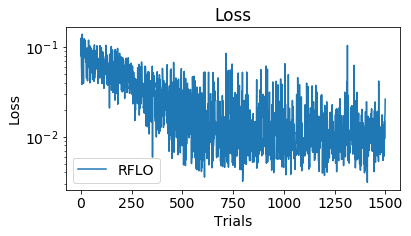

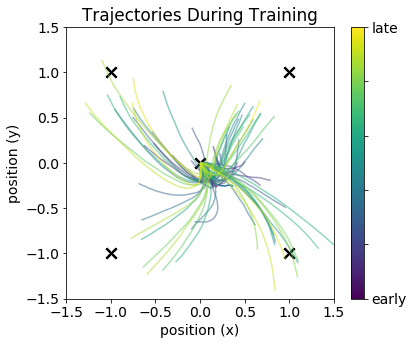

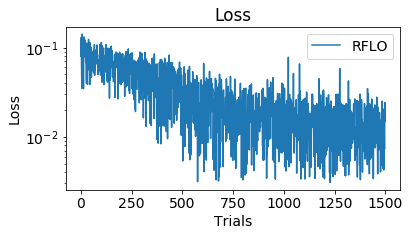

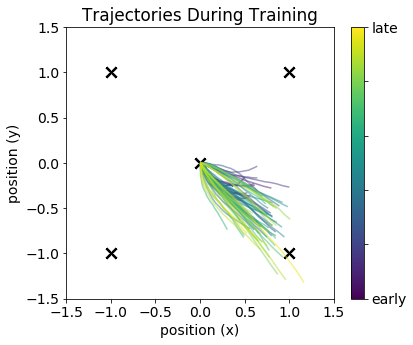

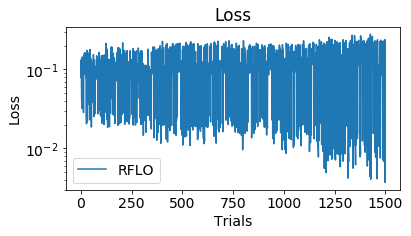

In [38]:

loss_dict = {}

overlaps = [0.8,0.6,0.4,0]
n_changes = [30,50,75,100]
for overlap, n_change in zip(overlaps,n_changes):
    
    net1a = RNN(params)
    
    M = choose_aligned_matrix(net1a.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000,rng=np.random.RandomState(1977))
    net1a.set_weights(w_m = M.T)
    
    sim1a = Simulation(net1a)
    rfloa = RFLO(net1a,apply_to=['w_rec'],online=False)
    sim1a.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[rfloa], probe_types=['loss'], plot=True, plot_freq=20)

    av1a = uniform_filter1d(np.mean(sim1a.session_probes['loss'],axis=1),25)
    
    loss_dict[str(overlap)] = av1a


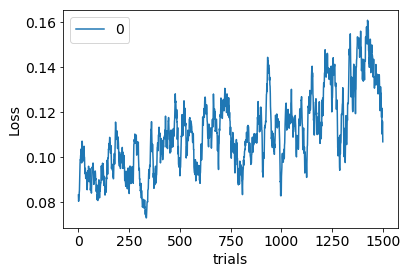

In [37]:
fig,ax = plt.subplots(1,1)
for overlap,loss in loss_dict.items():
    ax.plot(loss,label=overlap)

ax.set_ylabel('Loss')
ax.set_xlabel('trials')
ax.legend()
plt.show()

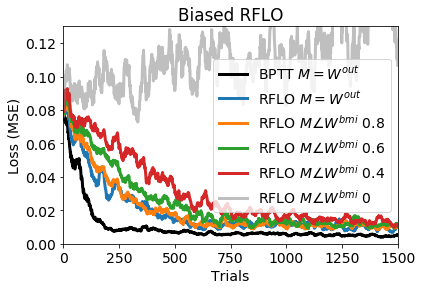

In [39]:
lw=3

fig,ax = plt.subplots(1,1)
av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),25)
ax.plot(av0,linewidth=lw,label='BPTT '+'$M=W^{out}$',color='k')

av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),25)
ax.plot(av1,linewidth=lw,label='RFLO '+r'$M = W^{out}$')



for overlap,loss in loss_dict.items():
    
    if overlap != '0' and overlap != '1':
        ax.plot(loss,linewidth=lw,label='RFLO '+r'$M \angle W^{bmi}$ '+overlap)
        
    if overlap == '0':
        ax.plot(loss,linewidth=lw,label='RFLO '+r'$M \angle W^{bmi}$ '+overlap,alpha=0.5,color='grey')

#ax.legend(bbox_to_anchor=(0.7,1))
ax.legend()
ax.set_xlabel('Trials')
ax.set_ylabel('Loss (MSE)')
ax.set_ylim([0,0.13])
ax.set_xlim([0,1500])
plt.title('Biased RFLO')
plt.show()

save = True
if save:
    fig.savefig(folder+'example-RFLO-changeM.pdf')

# BPTT Biased

23it [00:00, 229.61it/s]

M norm: 0.99	 M angle: 0.81, 5 iterations>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:04, 324.15it/s]
20it [00:00, 198.43it/s]

M norm: 1.36	 M angle: 0.61, 11 iterations>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:03, 386.89it/s]
35it [00:00, 345.99it/s]

M norm: 1.58	 M angle: 0.40, 3 iterations>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:03, 402.98it/s]
19it [00:00, 189.57it/s]

M norm: 1.67	 M angle: 0.31, 16 iterations>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:04, 367.05it/s]
35it [00:00, 349.17it/s]

M norm: 1.87	 M angle: 0.00, 5 iterations>> TODO: Learning rule for w_fb not currently implemented for BPTT
>> TODO: implement weight_transport=False (of w_m) for BPTT


1500it [00:04, 337.86it/s]


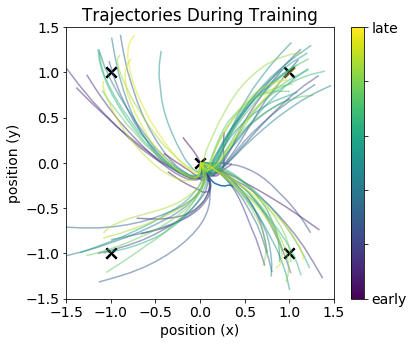

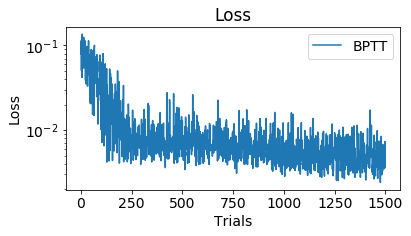

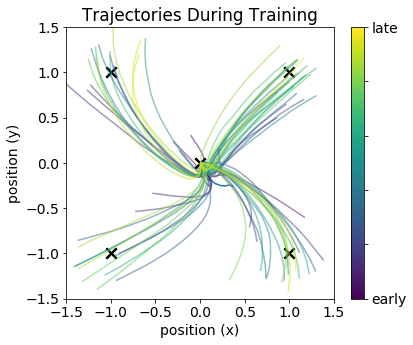

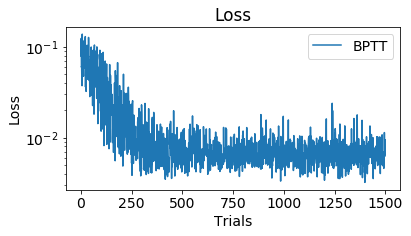

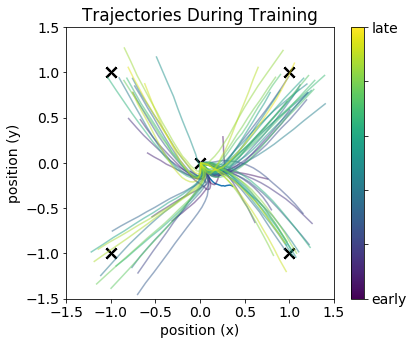

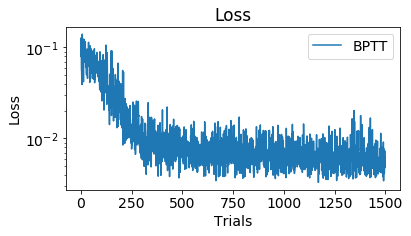

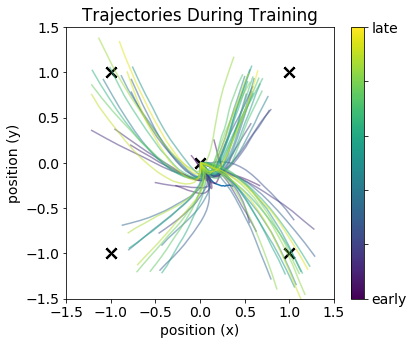

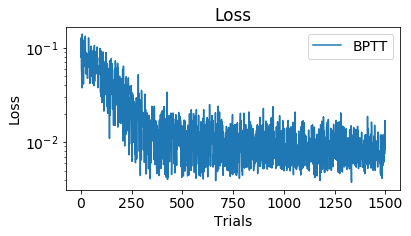

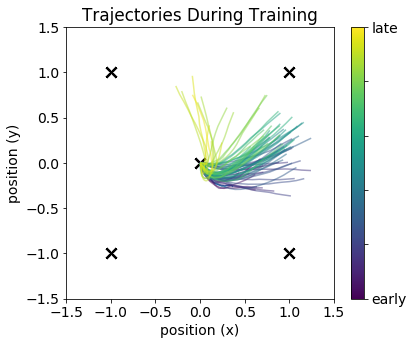

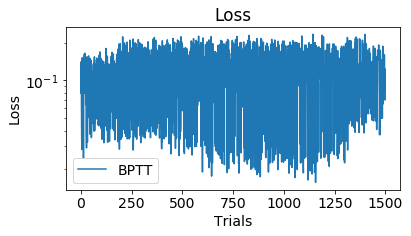

In [25]:
loss_dict_bptt = {}

overlaps = [0.8,0.6,0.4,0.3,0]
n_changes = [30,50,75,80,100]
for overlap, n_change in zip(overlaps,n_changes):
    
    net1a = RNN(params)
    
    M = choose_aligned_matrix(net1a.w_out.copy(),n_change=n_change,overlap=overlap,zero=False,tolerance=0.01,loop=1000,rng=np.random.RandomState(1976))
    net1a.set_weights(w_m = M.T)
    
    sim1a = Simulation(net1a)
    bptta = BPTT(net1a,apply_to=['w_rec'],online=False)
    sim1a.run_session(n_trials=1500, tasks=[task1,task2,task3,task4], learn_alg=[bptta], probe_types=['loss'], plot=True, plot_freq=20)

    av1a = uniform_filter1d(np.mean(sim1a.session_probes['loss'],axis=1),25)
    
    loss_dict_bptt[str(overlap)] = av1a

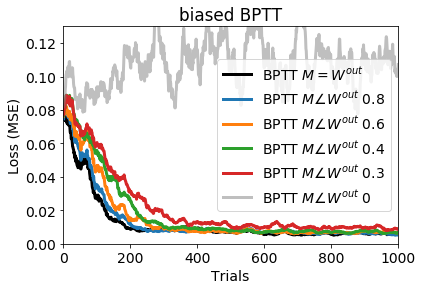

In [34]:
lw=3

fig,ax = plt.subplots(1,1)
av0 = uniform_filter1d(np.mean(sim0.session_probes['loss'],axis=1),25)
ax.plot(av0,linewidth=lw,label='BPTT '+'$M=W^{out}$',color='k')

# av1 = uniform_filter1d(np.mean(sim1.session_probes['loss'],axis=1),25)
# ax.plot(av1,linewidth=lw,label='RFLO '+r'$M = W^{out}$')



for overlap,loss in loss_dict_bptt.items():
    
    if overlap != '0' and overlap != '1':
        ax.plot(loss,linewidth=lw,label='BPTT '+r'$M \angle W^{out}$ '+overlap)
        
    if overlap == '0':
        ax.plot(loss,linewidth=lw,label='BPTT '+r'$M \angle W^{out}$ '+overlap,alpha=0.5,color='grey')

#ax.legend(bbox_to_anchor=(0.7,1))
ax.legend()
ax.set_xlabel('Trials')
ax.set_ylabel('Loss (MSE)')
ax.set_ylim([0,0.13])
ax.set_xlim([0,1000])
plt.title('biased BPTT')
plt.show()

save = True
if save:
    fig.savefig(folder+'example-BPTT-changeM.pdf')

# REINFORCE with Noise

50000it [02:04, 401.98it/s]
50000it [01:52, 443.64it/s]
50000it [02:03, 405.82it/s]
50000it [01:45, 474.76it/s]


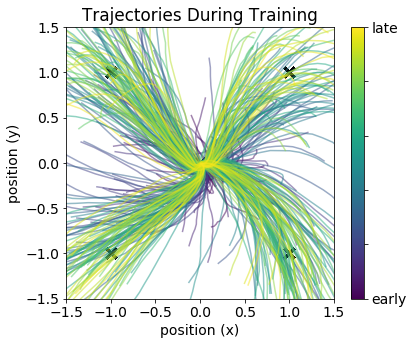

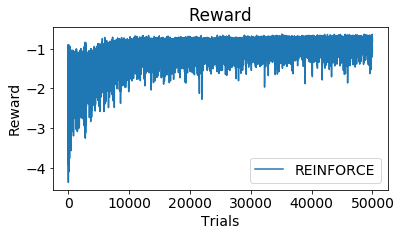

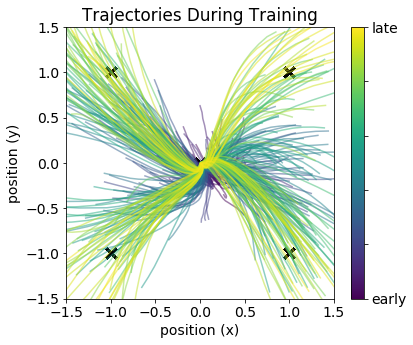

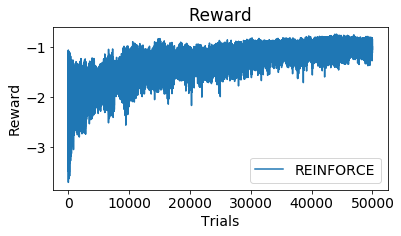

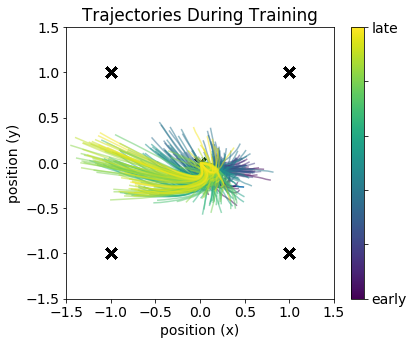

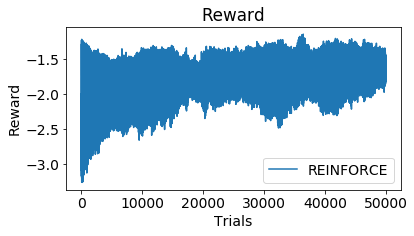

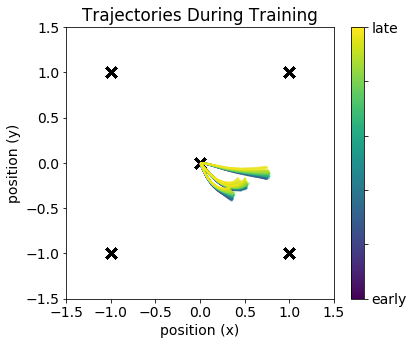

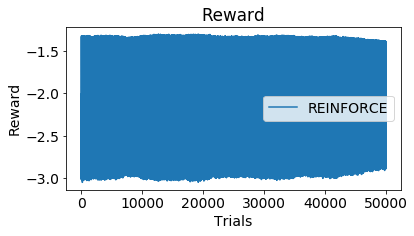

In [56]:

rpe_dict_reinforce = {}

noise = [0.5,0.25,0.1,0.01]
for sig_rec in noise:
    
    params2a = RNNparams(n_in=4,n_rec=50,n_out=2,tau_rec=10,
               eta_in=0.1,eta_rec=0.25,eta_out=0.1,
               sig_in=0.0,sig_rec=sig_rec,sig_out=0.01,
               velocity_transform=True, tau_vel = 0.8, dt_vel = 0.1,
               rng=np.random.RandomState(4))
    
    net2a = RNN(params2a)
    sim2a = Simulation(net2a)
    reinforce = REINFORCE(net2a,apply_to=['w_rec'],online=False, tau_reward=5)
    sim2a.run_session(n_trials=50000, tasks=[task1,task2,task3,task4], learn_alg=[reinforce], probe_types=['reward'], plot=True, plot_freq=100)

    


    av1a = uniform_filter1d(np.mean(sim2a.session_probes['reward'],axis=1),25)
    
    rpe_dict_reinforce[str(sig_rec)] = av1a




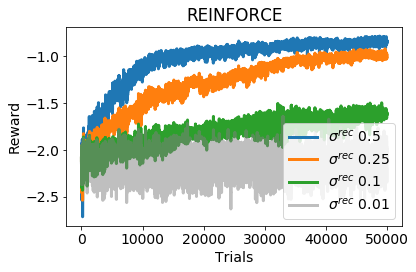

In [58]:
lw=3

fig,ax = plt.subplots(1,1)


for sig_rec,rpe in rpe_dict_reinforce.items():
    
    if float(sig_rec) > 0.05:
        ax.plot(rpe,linewidth=lw,label=''+r'$ \sigma^{rec}$ '+sig_rec)
    else:
        ax.plot(rpe,linewidth=lw,label=''+r'$ \sigma^{rec}$ '+sig_rec,color='gray',alpha=0.5)
        

#ax.legend(bbox_to_anchor=(0.7,1))
ax.legend()
ax.set_xlabel('Trials')
ax.set_ylabel('Reward')
#ax.set_ylim([0,0.13])
#ax.set_xlim([0,1000])
plt.title('REINFORCE')
plt.tight_layout()
plt.show()

save = True
if save:
    fig.savefig(folder+'example-REINFORCE-change-sigma.pdf')